In [1]:
import time, joblib, os
import seaborn as sns
import numpy as np
import lightgbm as lgb
import pandas as pd

from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from utils.dataset import load_dataset
from scipy.stats import entropy

In [2]:
data_root_path = 'data'+os.sep
data_paths = os.listdir('data')
start_time = time.strftime('%Y%m%d-%H%M%S', time.localtime(time.time()))

In [3]:
train_dataset_indices = [12, 16, 13, 15, 14, 10, 9, 11, 4, 3, 1, 5, 7, 6, 2, 8, 17, 21, 18, 24, 23, 19, 20, 22]         
val_dataset_indices = [31, 30, 26, 28, 29, 27, 25, 32]

In [4]:
train_dataset, val_dataset = load_dataset(train_dataset_indices=np.array(train_dataset_indices),
                                          val_dataset_indices=np.array(val_dataset_indices))
print(train_dataset.info())
print(val_dataset.info())

load dataset: 100%|████████████████████████████| 32/32 [00:00<00:00, 266.67it/s]

<class 'pandas.core.frame.DataFrame'>
Index: 51493 entries, 0 to 2510
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   main_pump_inlet_P(bar)      51493 non-null  float64
 1   main_pump_outlet_P(bar)     51493 non-null  float64
 2   venturi_pump_inlet_P(bar)   51493 non-null  float64
 3   venturi_pump_outlet_F(LPM)  51493 non-null  float64
dtypes: float64(4)
memory usage: 2.0 MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 16607 entries, 0 to 2023
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   main_pump_inlet_P(bar)      16607 non-null  float64
 1   main_pump_outlet_P(bar)     16607 non-null  float64
 2   venturi_pump_inlet_P(bar)   16607 non-null  float64
 3   venturi_pump_outlet_F(LPM)  16607 non-null  float64
dtypes: float64(4)
memory usage: 648.7 KB
None


In [5]:
train_dataset = train_dataset[train_dataset['main_pump_inlet_P(bar)']<2]
train_dataset = train_dataset[train_dataset['main_pump_outlet_P(bar)']>0]
train_dataset = train_dataset[train_dataset['venturi_pump_inlet_P(bar)']>0]
train_dataset = train_dataset[train_dataset['venturi_pump_outlet_F(LPM)']>0]
train_dataset.reset_index(drop=True, inplace=True)

train_dataset

,main_pump_inlet_P(bar),main_pump_outlet_P(bar),venturi_pump_inlet_P(bar),venturi_pump_outlet_F(LPM)
0,-1.837,0.007,0.323,26.620
1,-1.942,0.007,0.347,25.788
2,-1.900,0.009,0.330,26.744
3,-1.769,0.008,0.380,26.440
4,-1.879,0.013,0.384,26.029
...,...,...,...,...
26624,-1.693,0.007,0.453,885.706
26625,-2.162,0.004,0.474,881.773
26626,-1.837,0.003,0.463,875.266
26627,-1.762,0.001,0.420,873.333


In [6]:
val_dataset = val_dataset[val_dataset['main_pump_inlet_P(bar)']<2]
val_dataset = val_dataset[val_dataset['main_pump_outlet_P(bar)']>0]
val_dataset = val_dataset[val_dataset['venturi_pump_inlet_P(bar)']>0]
val_dataset = val_dataset[val_dataset['venturi_pump_outlet_F(LPM)']>0]
val_dataset.reset_index(drop=True, inplace=True)

val_dataset

,main_pump_inlet_P(bar),main_pump_outlet_P(bar),venturi_pump_inlet_P(bar),venturi_pump_outlet_F(LPM)
0,-2.079,0.084,0.652,1.748
1,-1.962,0.085,0.686,5.638
2,-1.876,0.086,0.690,8.809
3,-1.775,0.091,0.707,10.335
4,-1.918,0.093,0.710,10.548
...,...,...,...,...
9300,-1.829,0.012,0.470,910.229
9301,-1.893,0.010,0.467,910.098
9302,-1.728,0.005,0.449,910.804
9303,-2.049,0.005,0.443,908.185


2.6024527961599495

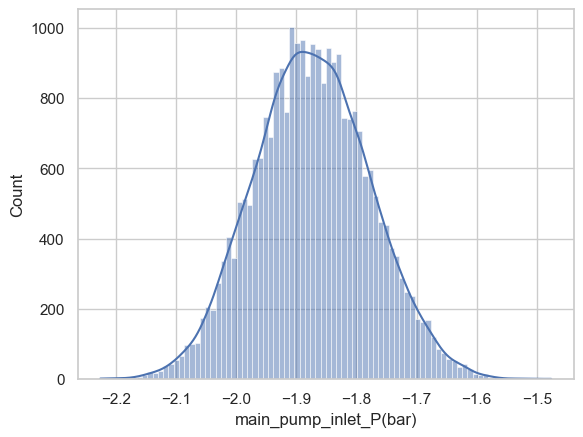

In [7]:
sns.set(style="whitegrid")
sns.histplot(train_dataset['main_pump_inlet_P(bar)'], kde='True')
prob = np.histogram(train_dataset['main_pump_inlet_P(bar)'], bins=np.linspace(-3, -1, 31))
entropy(pk=prob[0]/len(train_dataset['main_pump_inlet_P(bar)']), base=2)

1.5951302582709768

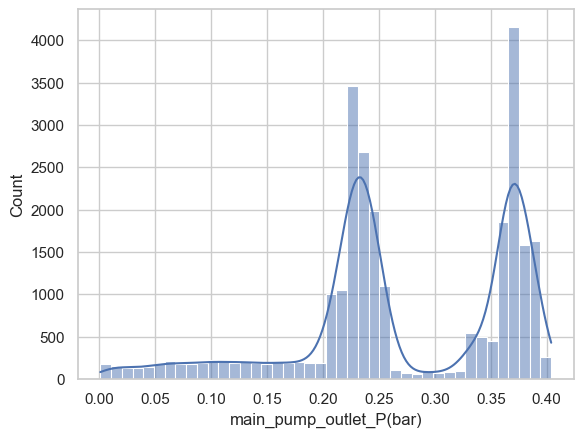

In [8]:
sns.set(style="whitegrid")
sns.histplot(train_dataset['main_pump_outlet_P(bar)'], kde='True')
prob = np.histogram(train_dataset['main_pump_outlet_P(bar)'], bins=np.linspace(-1, 1, 21))
entropy(pk=prob[0]/len(train_dataset['main_pump_outlet_P(bar)']), base=2)

<Axes: xlabel='venturi_pump_outlet_F(LPM)', ylabel='Count'>

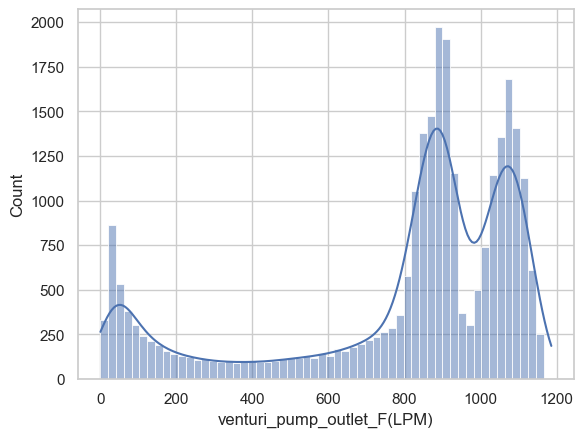

In [9]:
sns.histplot(train_dataset['venturi_pump_outlet_F(LPM)'], kde='True')

0.07846886961931605

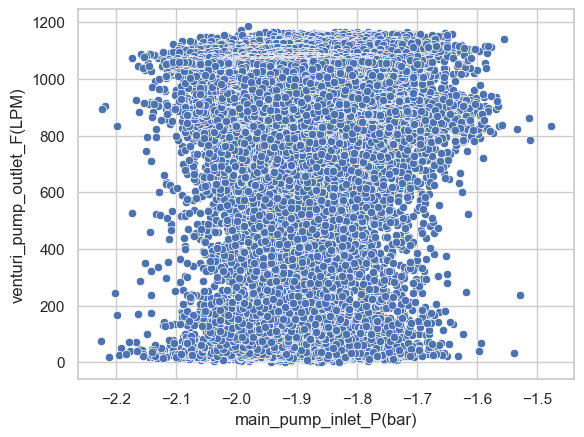

In [10]:
sns.scatterplot(x=train_dataset['main_pump_inlet_P(bar)'], y=train_dataset['venturi_pump_outlet_F(LPM)'])
np.corrcoef(train_dataset['main_pump_inlet_P(bar)'], train_dataset['venturi_pump_outlet_F(LPM)'])[0, 1]

0.37161837570597117

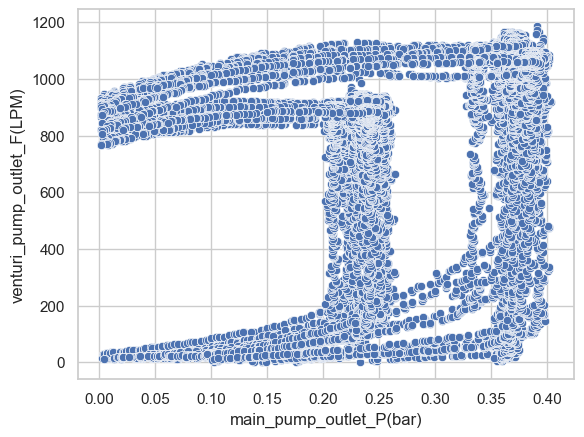

In [11]:
sns.scatterplot(x=train_dataset['main_pump_outlet_P(bar)'], y=train_dataset['venturi_pump_outlet_F(LPM)'])
np.corrcoef(train_dataset['main_pump_outlet_P(bar)'], train_dataset['venturi_pump_outlet_F(LPM)'])[0, 1]

0.4358757023641807

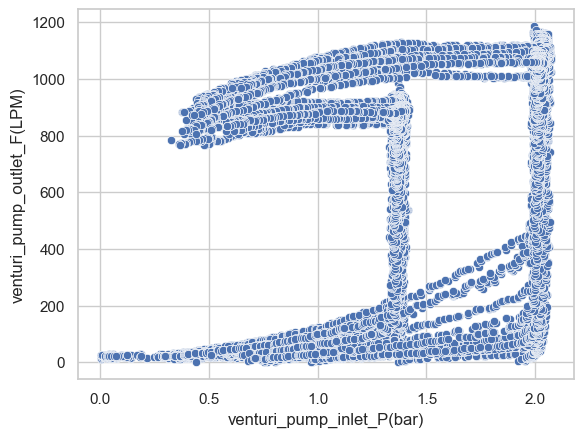

In [12]:
sns.scatterplot(x=train_dataset['venturi_pump_inlet_P(bar)'], y=train_dataset['venturi_pump_outlet_F(LPM)'])
np.corrcoef(train_dataset['venturi_pump_inlet_P(bar)'], train_dataset['venturi_pump_outlet_F(LPM)'])[0, 1]

In [13]:
train_feature = train_dataset.drop(columns='venturi_pump_outlet_F(LPM)')
train_target = train_dataset['venturi_pump_outlet_F(LPM)']

val_feature = val_dataset.drop(columns='venturi_pump_outlet_F(LPM)')
val_target = val_dataset['venturi_pump_outlet_F(LPM)']

In [14]:
nor_train_feature = train_feature.copy()
nor_train_target = train_target.copy()

nor_val_feature = val_feature.copy()
nor_val_target = val_target.copy()

nor_train_feature['main_pump_inlet_P(bar)'] = (nor_train_feature['main_pump_inlet_P(bar)']*0.6667)+1.6667
nor_train_feature['main_pump_outlet_P(bar)'] = nor_train_feature['main_pump_outlet_P(bar)']*2
nor_train_feature['venturi_pump_inlet_P(bar)'] = nor_train_feature['venturi_pump_inlet_P(bar)']*0.45

In [15]:
# create linear regression model
linear_model = LinearRegression()
linear_model.fit(train_feature, train_target)

LinearRegression()

In [16]:
pred_output = linear_model.predict(val_feature)
print('The Linear model: mae of prediction is:', f'{mean_absolute_error(val_target, pred_output):.2f}', end='\n\n')

pred_result = np.vstack((val_target.to_numpy(), pred_output)).T
np.savetxt('result' + os.sep + 'linear_result.csv', pred_result, delimiter=",")
print('linear model result data is saved!', end='\n\n')

print(r2_score(val_target, pred_output))

The Linear model: mae of prediction is: 233.81

linear model result data is saved!

0.23868314045293637


In [17]:
# create LightGBM model
param = {'objective':'regression',
         "boosting": "rf", "bagging_freq" : 1 , "bagging_fraction" : 0.8,
         "metric": 'l2', "verbosity": 1,
         "num_threads" : 4}

In [18]:
est_flow_model = lgb.LGBMRegressor(**param)
est_flow_model.fit(X=train_feature, y=train_target, eval_set=(val_feature, val_target), eval_metric='L2') 

[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 736
[LightGBM] [Info] Number of data points in the train set: 26629, number of used features: 3
[LightGBM] [Info] Start training from score 792.531409


LGBMRegressor(bagging_fraction=0.8, bagging_freq=1, boosting='rf', metric='l2',
              num_threads=4, objective='regression', verbosity=1)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

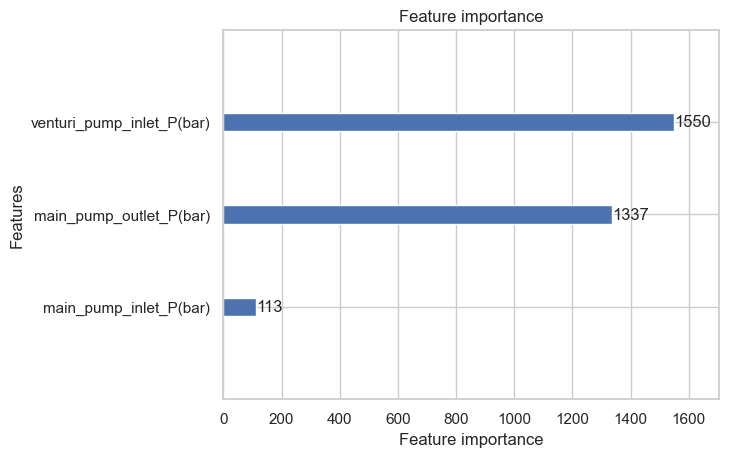

In [19]:
lgb.plot_importance(est_flow_model)

[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
The mae of prediction is: 189.0

result of lgb model is saved!

lgb model is saved!
0.4359755444468658


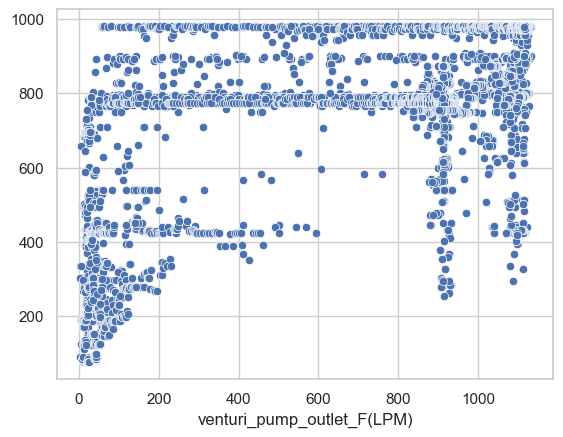

In [20]:
pred_output = est_flow_model.predict(val_feature, num_iteration=est_flow_model._best_iteration)
print('The mae of prediction is:', f'{mean_absolute_error(val_target, pred_output):.1f}', end='\n\n')

lgb_result = np.vstack((val_target.to_numpy(), pred_output)).T
np.savetxt('result' + os.sep + 'lgb_result.csv', lgb_result, delimiter=",")
print('result of lgb model is saved!', end='\n\n')

# save model
joblib.dump(est_flow_model, 'saved_model' + os.sep + 'new_model' + '.pkl')
print('lgb model is saved!')
sns.scatterplot(x=val_target, y=pred_output)

print(r2_score(val_target, pred_output))

In [21]:
poly = PolynomialFeatures(degree=3, include_bias=True)
train_poly_feature = pd.DataFrame(poly.fit_transform(train_feature))
val_poly_feature = pd.DataFrame(poly.fit_transform(val_feature))

In [22]:
linear_est_flow = linear_model.predict(train_feature)
#dart_est_flow = est_flow_model.predict(train_feature)
new_train_feature = train_feature.copy()
new_train_feature['linear_est'] = linear_est_flow
# new_train_feature['dart_est'] = dart_est_flow
new_train_feature['pipe_drop_p'] = train_feature['venturi_pump_inlet_P(bar)']-train_feature['main_pump_outlet_P(bar)']
new_train_feature = pd.concat([new_train_feature, train_poly_feature], axis=1)

linear_est_flow = linear_model.predict(val_feature)
#dart_est_flow = est_flow_model.predict(val_feature)
new_val_feature = val_feature.copy()
new_val_feature['linear_est'] = linear_est_flow
#new_val_feature['dart_est'] = dart_est_flow
new_val_feature['pipe_drop_p'] = val_feature['venturi_pump_inlet_P(bar)']-val_feature['main_pump_outlet_P(bar)']
new_val_feature = pd.concat([new_val_feature, val_poly_feature], axis=1)

In [130]:
# create LightGBM model
depth = 5
leaves = 2**depth
lr = 0.001
n_estimators = 5000
boosting_type = 'gbdt'
max_bin = 30
n_leaf = 1200

depth_list = list(range(1, 15, 1))
leaves_list = list(range(2, 100, 1))

In [131]:
new_est_flow_model = lgb.LGBMRegressor(n_estimators=n_estimators, learning_rate=lr, boosting_type=boosting_type, max_depth=-1, num_leaves=leaves,
                                       force_col_wise=True, verbose=1, n_jobs=-1)

In [132]:
new_est_flow_model.fit(X=new_train_feature, y=train_target, eval_set=(new_val_feature, val_target), eval_metric='L2', 
                       callbacks=[lgb.early_stopping(stopping_rounds=1000, min_delta=0.01), lgb.log_evaluation(period=100)])

[LightGBM] [Info] Total Bins 6004
[LightGBM] [Info] Number of data points in the train set: 26629, number of used features: 24
[LightGBM] [Info] Start training from score 792.531409
Training until validation scores don't improve for 1000 rounds
[100]	valid_0's l2: 101137
[200]	valid_0's l2: 93503.8
[300]	valid_0's l2: 87156.8
[400]	valid_0's l2: 81897.6
[500]	valid_0's l2: 77462.4
[600]	valid_0's l2: 73750.5
[700]	valid_0's l2: 70664.6
[800]	valid_0's l2: 68089.3
[900]	valid_0's l2: 65928.1
[1000]	valid_0's l2: 64095.4
[1100]	valid_0's l2: 62536.9
[1200]	valid_0's l2: 61216.8
[1300]	valid_0's l2: 60097.1
[1400]	valid_0's l2: 59143.6
[1500]	valid_0's l2: 58337.1
[1600]	valid_0's l2: 57652.2
[1700]	valid_0's l2: 57080.2
[1800]	valid_0's l2: 56581.3
[1900]	valid_0's l2: 56135.2
[2000]	valid_0's l2: 55751.7
[2100]	valid_0's l2: 55403.7
[2200]	valid_0's l2: 55073.5
[2300]	valid_0's l2: 54781.4
[2400]	valid_0's l2: 54559.5
[2500]	valid_0's l2: 54371.5
[2600]	valid_0's l2: 54216.3
[2700]	vali

LGBMRegressor(force_col_wise=True, learning_rate=0.001, n_estimators=5000,
              n_jobs=-1, num_leaves=32, verbose=1)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

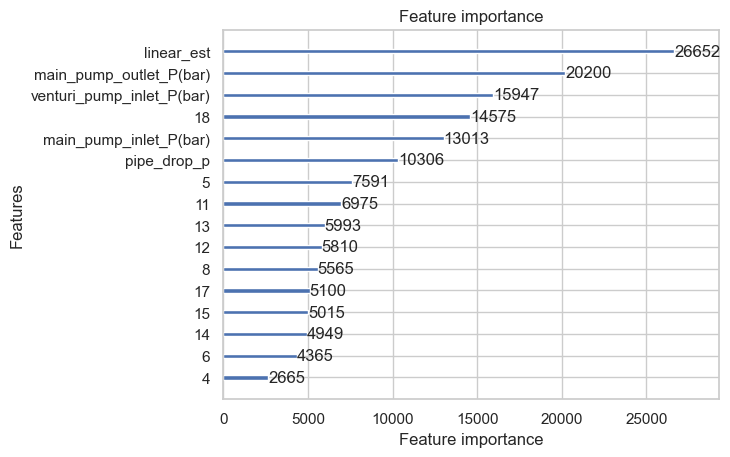

In [133]:
lgb.plot_importance(new_est_flow_model, max_num_features=30)

The mae of prediction is: 170.3

result of new lgb model is saved!

new lgb model is saved!
0.5165313009517445


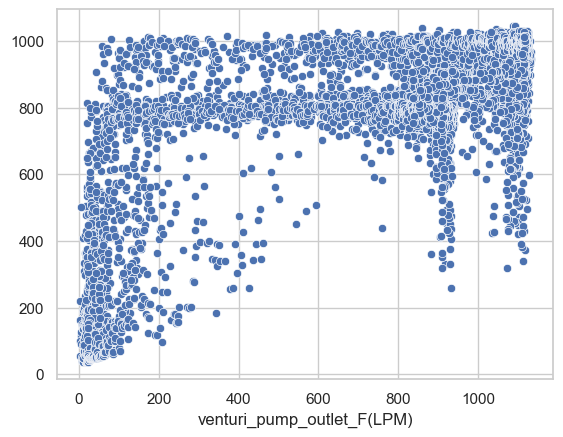

In [134]:
pred_output = new_est_flow_model.predict(new_val_feature, num_iteration=new_est_flow_model._best_iteration)
print('The mae of prediction is:', f'{mean_absolute_error(val_target, pred_output):.1f}', end='\n\n')

new_lgb_result = np.vstack((val_target.to_numpy(), pred_output)).T
np.savetxt('result' + os.sep + 'new_lgb_result.csv', new_lgb_result, delimiter=",")
print('result of new lgb model is saved!', end='\n\n')

# save model
joblib.dump(est_flow_model, 'saved_model' + os.sep + 'new_model' + '.pkl')
print('new lgb model is saved!')

sns.scatterplot(x=val_target, y=pred_output)

print(r2_score(val_target, pred_output))
# lgb.create_tree_digraph(est_flow_model).render('display_graph' + os.sep + 'model' + '.gv', format='jpg', view=False)
